<a href="https://colab.research.google.com/github/rybak97/SR_cartoon/blob/main/EDSR_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation, MaxPooling2D

from scipy import signal
from scipy import ndimage

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os
from PIL import Image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


In [ ]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

In [ ]:
def Upsample_block(x,ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x
lr=tf.keras.layers.Input(shape=(128, 128, 3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

In [ ]:
def model():
    SRRes=input_conv
    for x in range(5):
        res_output=residual_block_gen()(SRRes)
        SRRes=Upsample_block(SRRes)
        SRRes=MaxPooling2D()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
    SRRes=tf.keras.layers.BatchNormalization()(SRRes)
    SRRes=tf.keras.layers.Add()([SRRes,input_conv])
    SRRes=Upsample_block(SRRes)
    SRRes=MaxPooling2D()(SRRes)



    output_sr=tf.keras.layers.Conv2D(3,9,activation='sigmoid',padding='same')(SRRes)
    return tf.keras.models.Model(lr,output_sr)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

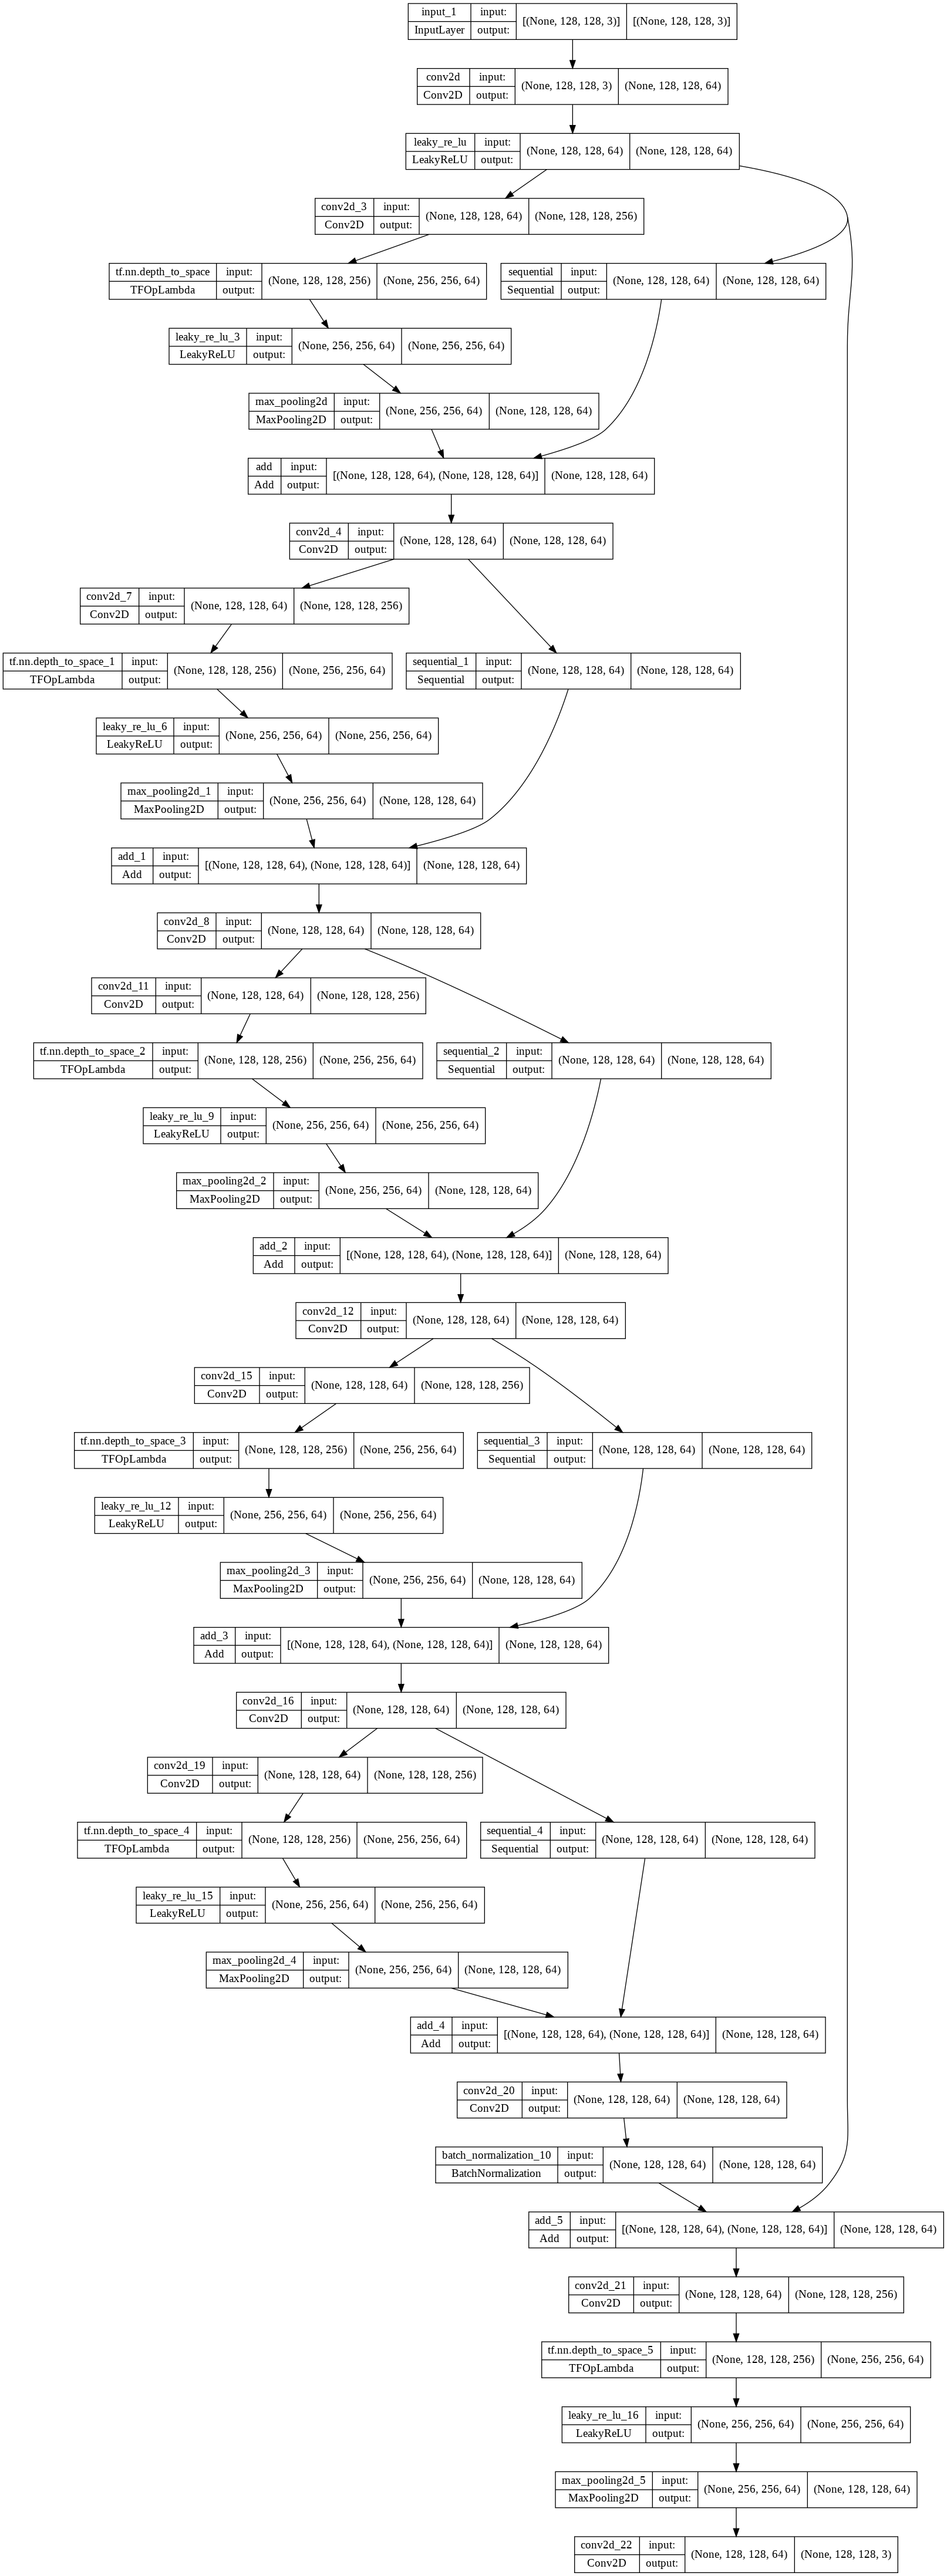

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
ishape = 128

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_image = train_images[0:5000]
test_image  = test_images[0:500]


X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.

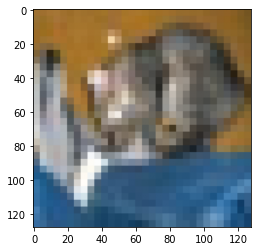

In [ ]:
plt.imshow(X_test[0])

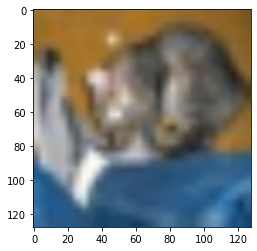

In [ ]:
plt.imshow(y_test[0])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='mse',       
              metrics=['mae'])    


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=2,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

#model.save('FSRCNN.h5')
#model.save_weights('model_weights.h5')

Epoch 1/2
250/250 [==============================] - 489s 2s/step - loss: 0.0056 - mae: 0.0537 - val_loss: 0.0151 - val_mae: 0.1010
Epoch 2/2
250/250 [==============================] - 465s 2s/step - loss: 0.0027 - mae: 0.0403 - val_loss: 0.0046 - val_mae: 0.0541
16/16 - 23s - loss: 0.0045 - mae: 0.0534 - 23s/epoch - 1s/step
Test loss: 0.004532047547399998
Test mae: 0.05335862562060356


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


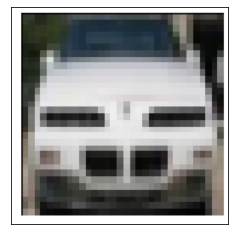

In [ ]:
ishape = 128

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

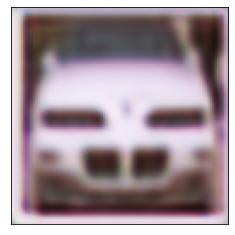

In [ ]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.


img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([16.205828], shape=(1,), dtype=float32)


In [ ]:
img = tf.reshape(img, [128,128,3,1])

img_SR = tf.reshape(img_SR, [128,128,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.3946786


2. pokemon dataset

In [ ]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

In [ ]:
def Upsample_block(x,ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x
lr=tf.keras.layers.Input(shape=(120, 120, 3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

In [ ]:
def model():
    SRRes=input_conv
    for x in range(5):
        res_output=residual_block_gen()(SRRes)
        SRRes=Upsample_block(SRRes)
        SRRes=MaxPooling2D()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
    SRRes=tf.keras.layers.BatchNormalization()(SRRes)
    SRRes=tf.keras.layers.Add()([SRRes,input_conv])
    SRRes=Upsample_block(SRRes)
    SRRes=MaxPooling2D()(SRRes)



    output_sr=tf.keras.layers.Conv2D(3,9,activation='sigmoid',padding='same')(SRRes)
    return tf.keras.models.Model(lr,output_sr)

In [ ]:
model2 = model()
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 120, 120, 64  0           ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
images = []


for file in os.listdir('/content/drive/MyDrive/images/'):
    images.append(cv.imread('/content/drive/MyDrive/images/{}'.format(file)))

In [ ]:
ishape = 120

for a in range(len(images)):
  images[a] = cv.cvtColor(images[a], cv.COLOR_BGR2RGB)



train_image = images[0:647]
test_image  = images[647:]

train_image2 = images[0:647] #czyste
test_image2  = images[647:]



for i in range(np.asarray(647)):

  
  train_image[i] = cv.blur(train_image[i],(7,7))
   


for i in range(np.asarray(809-647)):

  
  test_image[i] = cv.blur(test_image[i],(7,7))
 

X_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.


y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image2]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image2]) / 255.

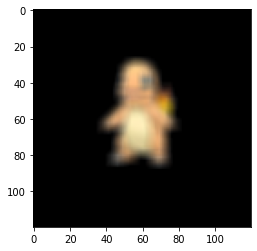

In [ ]:
plt.imshow(X_test[77])

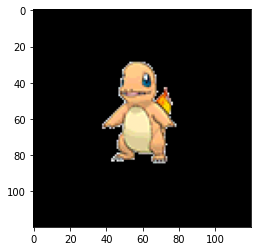

In [ ]:
plt.imshow(y_test[77])

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='mse',       
              metrics=['mae'])    

history = model2.fit(X_train, y_train,
                    batch_size=16,
                    epochs=3,
                    validation_split=0.2)

test_scores = model2.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

Epoch 1/3
33/33 [==============================] - 46s 1s/step - loss: 0.0318 - mae: 0.0945 - val_loss: 0.0727 - val_mae: 0.2359
Epoch 2/3
33/33 [==============================] - 43s 1s/step - loss: 0.0122 - mae: 0.0450 - val_loss: 0.0346 - val_mae: 0.1582
Epoch 3/3
33/33 [==============================] - 43s 1s/step - loss: 0.0109 - mae: 0.0415 - val_loss: 0.0239 - val_mae: 0.1147
6/6 - 4s - loss: 0.0233 - mae: 0.1139 - 4s/epoch - 681ms/step
Test loss: 0.02334672398865223
Test mae: 0.11388731002807617


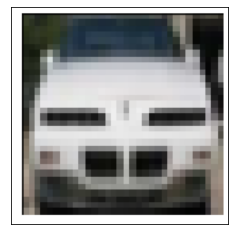

In [ ]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

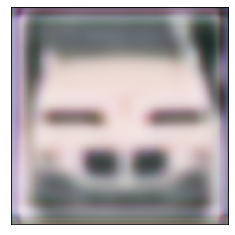

In [ ]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([11.086608], shape=(1,), dtype=float32)


In [ ]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.35458675


In [ ]:
model2.save('EDSR_2.h5')

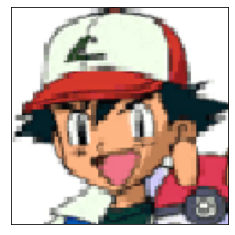

In [ ]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/Ash_OS_2.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

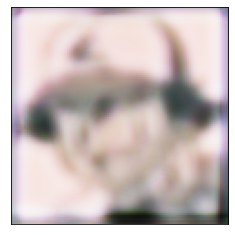

In [ ]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([12.561345], shape=(1,), dtype=float32)


In [ ]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.3079343


test